<a href="https://colab.research.google.com/github/kdemertzis/ML_BigData_CyberSecurity-test/blob/master/Ransomware_Detection/Ransomware_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ransomware ( Malware ) Detection using Machine Learning 
## Seminar Project

In [4]:
!pip install pefile

In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
dataset=pd.read_csv("https://raw.githubusercontent.com/muditmathur2020/RansomwareDetection/master/Ransomware.csv",sep='|')

# Exploring Dataset

In [6]:
dataset

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,6135,4096,372736,4194304.0,4096,512,0,0,0,0,1,0,1036288,1024,485887,16,1024,1048576,4096,1048576,4096,0,16,8,5.766807,3.607430,7.221051,59712.0,1024,325120,126875.875,896,551848,0,0,0,0,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,81778,4096,143360,771751936.0,4096,512,5,1,0,0,5,1,159744,1024,188943,2,33088,1048576,4096,1048576,4096,0,16,4,4.839688,2.373525,6.566909,35584.0,2048,130560,37322.000,1840,130296,7,181,0,0,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,350896,4096,811008,771751936.0,4096,512,5,1,0,0,5,1,1150976,1024,1159817,2,32832,1048576,4096,1048576,4096,0,16,4,6.409558,4.885191,7.600957,273408.0,21504,517120,284498.000,21456,516760,14,235,21,1,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,451258,4096,798720,771751936.0,4096,512,5,1,0,0,5,1,962560,1024,867570,2,33088,1048576,4096,1048576,4096,0,16,4,6.641731,5.642565,7.594929,207872.0,15360,585728,238502.000,15208,585488,15,360,6,1,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,217381,4096,536576,771751936.0,4096,512,5,1,0,0,5,1,552960,1024,579287,2,33088,1048576,4096,1048576,4096,0,16,4,6.252684,4.182282,7.608305,128128.0,2560,294912,135350.000,2320,294816,10,194,4,1,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,VirusShare_8e292b418568d6e7b87f2a32aee7074b,8e292b418568d6e7b87f2a32aee7074b,332,224,258,11,0,205824,223744,0,123291,4096,212992,4194304.0,4096,512,5,1,0,0,5,1,442368,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.787797,2.247185,6.516364,84070.4,7168,205824,85753.600,16340,205644,7,133,0,0,7,4.122736,1.370260,7.677091,14900.714286,16,81654,72,0,0
138043,VirusShare_260d9e2258aed4c8a3bbd703ec895822,260d9e2258aed4c8a3bbd703ec895822,332,224,33167,2,25,37888,185344,0,40000,4096,45056,4194304.0,4096,512,1,0,6,0,4,0,253952,1024,0,2,32768,1048576,16384,1048576,4096,0,16,8,2.256582,0.000000,6.562232,27904.0,0,181248,28451.500,8,180988,8,96,0,0,26,3.377663,2.031619,5.050074,6905.846154,44,67624,0,15,0
138044,VirusShare_8d088a51b7d225c9f5d11d239791ec3f,8d088a51b7d225c9f5d11d239791ec3f,332,224,258,10,0,118272,380416,0,59610,4096,122880,4194304.0,4096,512,5,1,0,0,5,1,516096,1024,515385,2,33088,1048576,4096,1048576,4096,0,16,5,5.659426,4.217938,7.977423,99737.6,9728,331264,101043.000,9304,330808,6,107,0,0,22,6.825406,2.617026,7.990487,14981.909091,48,22648,72,14,0
138045,VirusShare_4286dccf67ca220fe67635388229a9f3,4286dccf67ca220fe67635388229a9f

In [7]:
dataset.describe()

,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
count,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,138047.000000,1.380470e+05,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,138047.000000,138047.000000
mean,4259.069274,225.845632,4444.145994,8.619774,3.819286,2.425956e+05,4.504867e+05,1.009525e+05,1.719561e+05,5.779845e+04,2.213743e+05,5.350876e+14,7.323764e+03,694.386694,5.097843,1.092983,68.751983,64.851283,4.861895,1.444602,8.159750e+05,1297.876520,1.797959e+08,2.157403,22312.125283,9.302477e+05,5.445543e+03,1.031958e+06,3.429882e+04,3.608506e+04,7.908762e+04,4.994509,4.637599,2.259625,6.958913,1.871513e+05,1.956488e+04,6.506805e+05,1.884237e+05,2.109837e+04,6.349808e+05,5.462937,113.225648,4.338341,23.674263,22.050700,4.000127,2.434541,5.521610,5.545093e+04,1.818082e+04,2.465903e+05,4.656750e+05,12.363115,0.299340
std,10880.347245,5.121399,8186.782524,4.088757,11.862675,5.754485e+06,2.101599e+07,1.635288e+07,3.430553e+06,5.527658e+06,2.188020e+06,9.929589e+16,6.257687e+05,1289.921098,99.220192,77.551077,1185.886042,1139.691397,0.647720,181.180393,6.530065e+06,5595.523021,5.976192e+08,0.452940,15440.574817,5.550081e+05,1.804724e+04,1.817744e+05,7.906877e+06,8.904748e+06,1.466901e+07,1.915329,1.099464,1.831893,1.044297,7.735218e+06,3.540868e+05,3.007226e+07,4.180153e+06,3.543141e+05,1.285463e+07,4.362811,123.134704,34.776745,252.093958,136.494244,1.112981,0.815577,1.597403,7.799163e+06,6.502369e+06,2.124860e+07,2.608987e+07,6.798878,0.457971
min,332.000000,224.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.553600e+04,1.600000e+01,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,448.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.000000,0.000000,0.000000,0.000000,6.400000e+01,0.000000e+00,6.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,332.000000,224.000000,258.000000,8.000000,0.000000,3.020800e+04,2.457600e+04,0.000000e+00,1.272100e+04,4.096000e+03,2.867200e+04,4.194304e+06,4.096000e+03,512.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.843200e+05,1024.000000,1.065765e+05,2.000000,320.000000,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,0.000000e+00,1.600000e+01,4.000000,4.001088,0.020393,6.417698,1.868800e+04,5.120000e+02

# To Check For NULL Values

In [8]:
dataset.isnull().sum()

Name                           0
md5                            0
Machine                        0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeap

# Classifying Data Based on Whether Legitimate OR Malware

In [9]:
dataset.groupby(dataset['legitimate']).size()
#1 means legitimate, 0 means malware

legitimate
0    96724
1    41323
dtype: int64

([<matplotlib.patches.Wedge at 0x7fa6a3b91fd0>,
 [Text(0.6484073958497663, 0.8885763045497695, 'Legitimate'),
  Text(-0.6484073958497659, -0.8885763045497698, 'Malware')],
 [Text(0.35367676137259974, 0.4846779842998742, '30%'),
  Text(-0.35367676137259957, -0.48467798429987435, '70%')])

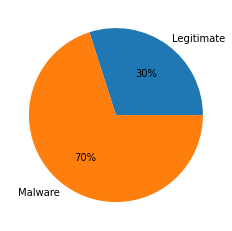

In [10]:
type_classify=['Legitimate','Malware']
count_classify=[41323,96724]
plt.pie(count_classify, labels=type_classify, autopct='%0.f%%')

# Total Number of Columns in Dataset

In [11]:
dataset.shape[1]

57

# Creating Legitimate and Malware Dataset from Main Dataset

In [12]:
legit=dataset[0:41323].drop(["legitimate"],axis=1) # here axis =1 means vertical 
legit

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,6135,4096,372736,4.194304e+06,4096,512,0,0,0,0,1,0,1036288,1024,485887,16,1024,1048576,4096,1048576,4096,0,16,8,5.766807,3.607430,7.221051,59712.0,1024,325120,126875.875,896,551848,0,0,0,0,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,81778,4096,143360,7.717519e+08,4096,512,5,1,0,0,5,1,159744,1024,188943,2,33088,1048576,4096,1048576,4096,0,16,4,4.839688,2.373525,6.566909,35584.0,2048,130560,37322.000,1840,130296,7,181,0,0,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,350896,4096,811008,7.717519e+08,4096,512,5,1,0,0,5,1,1150976,1024,1159817,2,32832,1048576,4096,1048576,4096,0,16,4,6.409558,4.885191,7.600957,273408.0,21504,517120,284498.000,21456,516760,14,235,21,1,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,451258,4096,798720,7.717519e+08,4096,512,5,1,0,0,5,1,962560,1024,867570,2,33088,1048576,4096,1048576,4096,0,16,4,6.641731,5.642565,7.594929,207872.0,15360,585728,238502.000,15208,585488,15,360,6,1,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,217381,4096,536576,7.717519e+08,4096,512,5,1,0,0,5,1,552960,1024,579287,2,33088,1048576,4096,1048576,4096,0,16,4,6.252684,4.182282,7.608305,128128.0,2560,294912,135350.000,2320,294816,10,194,4,1,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41318,mfc80.dll,1f5afd468eb5e09e9ed75a087529eab5,332,224,8450,8,0,946176,159744,0,808471,4096,950272,2.015166e+09,4096,4096,4,0,8,0,4,0,1110016,4096,1118533,2,320,1048576,4096,1048576,4096,0,16,4,5.167816,3.486792,6.543358,274432.0,20480,946176,274986.000,27016,946106,5,588,0,0,123,2.607251,0.960953,5.130762,327.170732,20,1592,72,16
41319,mfc80u.dll,e2c48cd0132d4d1dc7d0df9a6bef686a,332,224,8450,8,0,946176,154624,0,808738,4096,950272,2.016281e+09,4096,512,4,0,8,0,4,0,1110016,1024,1098806,2,320,1048576,4096,1048576,4096,0,16,4,5.248614,3.603001,6.524768,273024.0,18944,946176,274954.250,27528,945735,5,585,0,0,123,2.607232,0.960953,5.130762,327.235772,20,1592,72,16
41320,mfcm80.dll,83362ee950ad18adb85b54409155c378,332,224,8450,8,0,53248,16384,0,54048,4096,57344,2.085945e+09,4096,4096,4,0,8,0,4,0,73728,4096,120607,2,320,1048576,4096,1048576,4096,0,16,4,2.703736,1.056379,6.228190,16384.0,4096,53248,15939.000,992,52864,6,137,81,25,1,3.524268,3.524268,3.524268,892.000000,892,892,72,16
41321,mfcm80u.dll,26aafee5c30020c99120ee113d751f7e,332,224,8450,8,0,52736,11264,0,53530,4096,57344,2.086994e+09,4096,512,4,0,8,0,4,0,73728,1024,89230,2,320,1048576,4096,1048576,4096,0,16

In [13]:
mal=dataset[41323::]
maldata=dataset[41323::].drop(["legitimate"],axis=1)
mal

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
41323,VirusShare_4a400b747afe6547e09ce0b02dae7f1c,4a400b747afe6547e09ce0b02dae7f1c,332,224,258,11,0,354816,257024,0,183632,4096,360448,4194304.0,4096,512,5,1,0,0,5,1,626688,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.590397,2.378947,6.296826,120524.8,7680,354816,122148.600,16468,354799,7,138,0,0,7,3.914415,1.441688,7.677091,7298.428571,16,28438,72,0,0
41324,VirusShare_9bd57c8252948bd2fa651ad372bd4f13,9bd57c8252948bd2fa651ad372bd4f13,332,224,271,6,0,24064,164864,1024,12538,4096,28672,4194304.0,4096,512,4,0,6,0,4,0,241664,1024,0,2,32768,1048576,4096,1048576,4096,0,16,5,4.104541,0.000000,6.440106,6758.4,0,24064,46260.800,3144,154712,8,155,1,0,6,3.199107,1.971335,5.214816,452.000000,34,958,0,15,0
41325,VirusShare_d1456165e9358b8f61f93a5f2042f39c,d1456165e9358b8f61f93a5f2042f39c,332,224,258,10,0,118784,381952,0,59914,4096,122880,4194304.0,4096,512,5,1,0,0,5,1,520192,1024,558287,2,33088,1048576,4096,1048576,4096,0,16,5,5.662408,4.183692,7.961871,100147.2,9216,334848,101559.800,9368,334440,7,114,0,0,18,6.530946,2.458492,7.992688,18523.444444,48,33945,72,14,0
41326,VirusShare_e4214cc73afbba0f52bb72d5db8f8bb1,e4214cc73afbba0f52bb72d5db8f8bb1,332,224,258,10,0,174592,300032,0,117140,4096,180224,4194304.0,4096,512,5,1,0,0,5,1,487424,1024,513173,2,33088,1048576,4096,1048576,4096,0,16,5,5.735470,4.758260,7.364313,93081.6,15360,192000,94698.800,21500,191664,11,254,15,0,15,5.732393,2.852364,7.987726,12706.133333,118,60500,72,14,0
41327,VirusShare_710890c07b3f93b90635f8bff6c34605,710890c07b3f93b90635f8bff6c34605,332,224,258,9,0,475648,348672,0,319769,4096,483328,4194304.0,4096,512,5,0,0,0,5,0,856064,1024,1820725856,2,33088,1048576,4096,1048576,4096,0,16,5,5.139934,4.480790,6.558149,164864.0,13824,475648,168145.200,30840,475580,14,421,15,0,59,2.827826,0.960953,7.212329,2637.033898,20,67624,72,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,VirusShare_8e292b418568d6e7b87f2a32aee7074b,8e292b418568d6e7b87f2a32aee7074b,332,224,258,11,0,205824,223744,0,123291,4096,212992,4194304.0,4096,512,5,1,0,0,5,1,442368,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.787797,2.247185,6.516364,84070.4,7168,205824,85753.600,16340,205644,7,133,0,0,7,4.122736,1.370260,7.677091,14900.714286,16,81654,72,0,0
138043,VirusShare_260d9e2258aed4c8a3bbd703ec895822,260d9e2258aed4c8a3bbd703ec895822,332,224,33167,2,25,37888,185344,0,40000,4096,45056,4194304.0,4096,512,1,0,6,0,4,0,253952,1024,0,2,32768,1048576,16384,1048576,4096,0,16,8,2.256582,0.000000,6.562232,27904.0,0,181248,28451.500,8,180988,8,96,0,0,26,3.377663,2.031619,5.050074,6905.846154,44,67624,0,15,0
138044,VirusShare_8d088a51b7d225c9f5d11d239791ec3f,8d088a51b7d225c9f5d11d239791ec3f,332,224,258,10,0,118272,380416,0,59610,4096,122880,4194304.0,4096,512,5,1,0,0,5,1,516096,1024,515385,2,33088,1048576,4096,1048576,4096,0,16,5,5.659426,4.217938,7.977423,99737.6,9728,331264,10104

In [14]:
print("The shape of legit database is %s samples and %s features"%(legit.shape[0],legit.shape[1])) 
print("The shape of malware database is %s samples and %s features"%(mal.shape[0],mal.shape[1])) 

The shape of legit database is 41323 samples and 56 features
The shape of malware database is 96724 samples and 57 features


In [15]:
#to find the features ie the column names
print(dataset.columns) #but in malware or legit there is no legitimate feature :)
print(mal.columns)

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [16]:
#first 10 data points from malware database:
mal.head(10)

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
41323,VirusShare_4a400b747afe6547e09ce0b02dae7f1c,4a400b747afe6547e09ce0b02dae7f1c,332,224,258,11,0,354816,257024,0,183632,4096,360448,4194304.0,4096,512,5,1,0,0,5,1,626688,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.590397,2.378947,6.296826,120524.800000,7680,354816,122148.600000,16468,354799,7,138,0,0,7,3.914415,1.441688,7.677091,7298.428571,16,28438,72,0,0
41324,VirusShare_9bd57c8252948bd2fa651ad372bd4f13,9bd57c8252948bd2fa651ad372bd4f13,332,224,271,6,0,24064,164864,1024,12538,4096,28672,4194304.0,4096,512,4,0,6,0,4,0,241664,1024,0,2,32768,1048576,4096,1048576,4096,0,16,5,4.104541,0.000000,6.440106,6758.400000,0,24064,46260.800000,3144,154712,8,155,1,0,6,3.199107,1.971335,5.214816,452.000000,34,958,0,15,0
41325,VirusShare_d1456165e9358b8f61f93a5f2042f39c,d1456165e9358b8f61f93a5f2042f39c,332,224,258,10,0,118784,381952,0,59914,4096,122880,4194304.0,4096,512,5,1,0,0,5,1,520192,1024,558287,2,33088,1048576,4096,1048576,4096,0,16,5,5.662408,4.183692,7.961871,100147.200000,9216,334848,101559.800000,9368,334440,7,114,0,0,18,6.530946,2.458492,7.992688,18523.444444,48,33945,72,14,0
41326,VirusShare_e4214cc73afbba0f52bb72d5db8f8bb1,e4214cc73afbba0f52bb72d5db8f8bb1,332,224,258,10,0,174592,300032,0,117140,4096,180224,4194304.0,4096,512,5,1,0,0,5,1,487424,1024,513173,2,33088,1048576,4096,1048576,4096,0,16,5,5.735470,4.758260,7.364313,93081.600000,15360,192000,94698.800000,21500,191664,11,254,15,0,15,5.732393,2.852364,7.987726,12706.133333,118,60500,72,14,0
41327,VirusShare_710890c07b3f93b90635f8bff6c34605,710890c07b3f93b90635f8bff6c34605,332,224,258,9,0,475648,348672,0,319769,4096,483328,4194304.0,4096,512,5,0,0,0,5,0,856064,1024,1820725856,2,33088,1048576,4096,1048576,4096,0,16,5,5.139934,4.480790,6.558149,164864.000000,13824,475648,168145.200000,30840,475580,14,421,15,0,59,2.827826,0.960953,7.212329,2637.033898,20,67624,72,0,0
41328,VirusShare_3c2eb01508703752dca01957ea451a40,3c2eb01508703752dca01957ea451a40,332,224,259,9,0,157696,62464,0,67015,4096,163840,4194304.0,4096,512,5,0,0,0,5,0,233472,1024,272988,2,33024,1048576,4096,1048576,4096,0,16,4,4.819885,2.977365,6.485124,55040.000000,3584,157696,55626.750000,6700,157297,2,76,0,0,13,3.943296,1.814443,6.122045,2708.153846,132,9640,72,14,0
41329,VirusShare_3fb2d0ac00c5dff6c4fd5dfe6ba52c3f,3fb2d0ac00c5dff6c4fd5dfe6ba52c3f,332,224,259,83,82,724992,2306048,0,4243456,3522560,4308992,4194304.0,4096,4096,5,0,0,0,5,0,6709248,4096,3077047,2,32768,1048576,4096,1048576,4096,0,16,9,3.783125,0.000000,7.999518,336782.222222,0,1884160,744182.333333,2272,3061299,4,243,0,0,21,3.987463,2.642159,6.473700,14288.000000,76,270376,0,0,0
41330,VirusShare_ad1ca9a4d572c0a2793c4cea29b20887,ad1ca9a4d572c0a2793c4cea29b20887,332,224,258,10,0,120320,385024,0,61578,4096,126976,4194304.0,4096,512,5,1,0,0,5,1,528384,1024,566330,2,33088,1048576,4096,1048576,4096,0,16,5,5.646444,4.117264,7.962776,101068.800000,9728,330752,102623.800000,9404,339652,3,89,0,0,6,3.729824,2.458492,5.317552,2739.500000,48,9640,72,15,0
41331,VirusShare_7414edb3d0be66aa0816e6ed4b6b0a21,7414edb3d0b

In [17]:
#lets see the datapoint of legit to have a good comparison 
legit.take([0]) #1st datapoint

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,6135,4096,372736,4194304.0,4096,512,0,0,0,0,1,0,1036288,1024,485887,16,1024,1048576,4096,1048576,4096,0,16,8,5.766807,3.60743,7.221051,59712.0,1024,325120,126875.875,896,551848,0,0,0,0,4,3.262823,2.568844,3.537939,8797.0,216,18032,0,16


In [18]:
#lets see the datapoint of malware to have a good comparison 
mal.take([0]) #1st datapoint

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
41323,VirusShare_4a400b747afe6547e09ce0b02dae7f1c,4a400b747afe6547e09ce0b02dae7f1c,332,224,258,11,0,354816,257024,0,183632,4096,360448,4194304.0,4096,512,5,1,0,0,5,1,626688,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.590397,2.378947,6.296826,120524.8,7680,354816,122148.6,16468,354799,7,138,0,0,7,3.914415,1.441688,7.677091,7298.428571,16,28438,72,0,0


# Feature Extraction

In [19]:
x=dataset.drop(['Name','md5','legitimate'],axis=1).values #independent features
y=dataset['legitimate'].values #dependent variable

In [20]:
extratrees=ek.ExtraTreesClassifier().fit(x,y)
model=SelectFromModel(extratrees,prefit=True)
x_new=model.transform(x)
nbfeatures=x_new.shape[1]

In [21]:
nbfeatures

14

([<matplotlib.patches.Wedge at 0x7fa6a3cede90>,
 [Text(0.7884607600756525, 0.7670264857362649, 'Important Features'),
  Text(-0.7884607959827531, -0.7670264488257518, 'Not Important Features')],
 [Text(0.4300695054958104, 0.4183780831288717, '25%'),
  Text(-0.43006952508150165, -0.4183780629958646, '75%')])

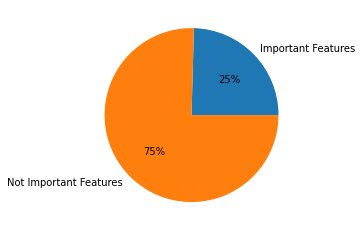

In [22]:
dataset.columns.size
imp_features_visual=['Important Features','Not Important Features']
imp_features_visual_val=[nbfeatures,57-nbfeatures]
plt.pie(imp_features_visual_val, labels=imp_features_visual, autopct='%0.f%%')

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.2)

In [24]:
features=[]
index=np.argsort(extratrees.feature_importances_)[::1][:nbfeatures]

In [25]:
for f in range(nbfeatures):
    print("%d. feature %s (%f)"%(f+1,dataset.columns[2+index[f]],extratrees.feature_importances_[index[f]]))
    features.append(dataset.columns[2+f])

1. feature LoaderFlags (0.000005)
2. feature NumberOfRvaAndSizes (0.000046)
3. feature SizeOfHeapCommit (0.000393)
4. feature BaseOfCode (0.000779)
5. feature SizeOfUninitializedData (0.001109)
6. feature SectionMaxVirtualsize (0.001137)
7. feature SizeOfImage (0.001160)
8. feature SectionsMeanVirtualsize (0.001192)
9. feature SectionMaxRawsize (0.001222)
10. feature ResourcesMaxSize (0.001224)
11. feature BaseOfData (0.001225)
12. feature ResourcesMeanSize (0.001232)
13. feature SizeOfInitializedData (0.001238)
14. feature SectionsMeanRawsize (0.001401)


In [26]:
model ={ "RandomForest":ek.RandomForestClassifier(n_estimators=50),
           "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
        "LogisticRegression":LogisticRegression()
       }

In [27]:
results={}
for algo in model:
    clf=model[algo]
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    print("%s : %s"%(algo,score))
    results[algo]=score

RandomForest : 0.9940239043824701
DecisionTree : 0.9900760593987685
LogisticRegression : 0.7028612821441507


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [28]:
winner=max(results,key=results.get)
winner

'RandomForest'

In [29]:
clf=model[winner]
res=clf.predict(x_new)
mt=confusion_matrix(y,res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print("False negative rate : %f %%" % ((mt[1][0] / float(sum(mt[1])))*100))

False positive rate : 0.105455 %
False negative rate : 0.176657 %


# Check for Multicollinearity

In [30]:
mc=dataset.drop(["Name",'md5','legitimate'],axis=1) #independent features
mc

,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
0,332,224,258,9,0,361984,115712,0,6135,4096,372736,4194304.0,4096,512,0,0,0,0,1,0,1036288,1024,485887,16,1024,1048576,4096,1048576,4096,0,16,8,5.766807,3.607430,7.221051,59712.0,1024,325120,126875.875,896,551848,0,0,0,0,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16
1,332,224,3330,9,0,130560,19968,0,81778,4096,143360,771751936.0,4096,512,5,1,0,0,5,1,159744,1024,188943,2,33088,1048576,4096,1048576,4096,0,16,4,4.839688,2.373525,6.566909,35584.0,2048,130560,37322.000,1840,130296,7,181,0,0,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18
2,332,224,3330,9,0,517120,621568,0,350896,4096,811008,771751936.0,4096,512,5,1,0,0,5,1,1150976,1024,1159817,2,32832,1048576,4096,1048576,4096,0,16,4,6.409558,4.885191,7.600957,273408.0,21504,517120,284498.000,21456,516760,14,235,21,1,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18
3,332,224,258,9,0,585728,369152,0,451258,4096,798720,771751936.0,4096,512,5,1,0,0,5,1,962560,1024,867570,2,33088,1048576,4096,1048576,4096,0,16,4,6.641731,5.642565,7.594929,207872.0,15360,585728,238502.000,15208,585488,15,360,6,1,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18
4,332,224,258,9,0,294912,247296,0,217381,4096,536576,771751936.0,4096,512,5,1,0,0,5,1,552960,1024,579287,2,33088,1048576,4096,1048576,4096,0,16,4,6.252684,4.182282,7.608305,128128.0,2560,294912,135350.000,2320,294816,10,194,4,1,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,332,224,258,11,0,205824,223744,0,123291,4096,212992,4194304.0,4096,512,5,1,0,0,5,1,442368,1024,0,2,33088,1048576,4096,1048576,4096,0,16,5,4.787797,2.247185,6.516364,84070.4,7168,205824,85753.600,16340,205644,7,133,0,0,7,4.122736,1.370260,7.677091,14900.714286,16,81654,72,0
138043,332,224,33167,2,25,37888,185344,0,40000,4096,45056,4194304.0,4096,512,1,0,6,0,4,0,253952,1024,0,2,32768,1048576,16384,1048576,4096,0,16,8,2.256582,0.000000,6.562232,27904.0,0,181248,28451.500,8,180988,8,96,0,0,26,3.377663,2.031619,5.050074,6905.846154,44,67624,0,15
138044,332,224,258,10,0,118272,380416,0,59610,4096,122880,4194304.0,4096,512,5,1,0,0,5,1,516096,1024,515385,2,33088,1048576,4096,1048576,4096,0,16,5,5.659426,4.217938,7.977423,99737.6,9728,331264,101043.000,9304,330808,6,107,0,0,22,6.825406,2.617026,7.990487,14981.909091,48,22648,72,14
138045,332,224,33166,2,25,49152,16896,0,51216,4096,53248,4194304.0,4096,512,1,0,0,0,4,0,90112,1024,0,2,0,1048576,16384,1048576,4096,0,16,8,3.012682,0.000000,6.431188,8256.0,0,49152,8362.875,12,48696,9,101,0,0,10,3.421627,2.060964,4.739744,601.600000,16,2216,0,0


In [31]:
for i in range(len(mc.columns[:-1])):
    v=vif(np.matrix(mc[:-1]),i)
    print("Variance Inflation Factor for {}: {}".format(mc.columns[i],round(v,2)))

Variance Inflation Factor for Machine: 1.19
Variance Inflation Factor for SizeOfOptionalHeader: 0.02
Variance Inflation Factor for Characteristics: 1.44
Variance Inflation Factor for MajorLinkerVersion: 1.19
Variance Inflation Factor for MinorLinkerVersion: 1.5
Variance Inflation Factor for SizeOfCode: 5.13
Variance Inflation Factor for SizeOfInitializedData: 1.57
Variance Inflation Factor for SizeOfUninitializedData: 1.0
Variance Inflation Factor for AddressOfEntryPoint: 1.07
Variance Inflation Factor for BaseOfCode: 4.27
Variance Inflation Factor for BaseOfData: 1.92
Variance Inflation Factor for ImageBase: 1.0
Variance Inflation Factor for SectionAlignment: 2.06
Variance Inflation Factor for FileAlignment: 1.08
Variance Inflation Factor for MajorOperatingSystemVersion: 1.0
Variance Inflation Factor for MinorOperatingSystemVersion: 4.16
Variance Inflation Factor for MajorImageVersion: 202.01
Variance Inflation Factor for MinorImageVersion: 186.06
Variance Inflation Factor for MajorSu

In [ ]:
count=0
for i in range(len(mc.columns[:-1])):
    v=vif(np.matrix(mc[:-1]),i)
    if v>10:
        print("Variance Inflation Factor for {} : {}".format(mc.columns[i],round(v,2)))
        count=count+1
print(count)           

Variance Inflation Factor for MajorImageVersion : 202.01
Variance Inflation Factor for MinorImageVersion : 186.06
Variance Inflation Factor for MinorSubsystemVersion : 17379.41
Variance Inflation Factor for SizeOfHeapCommit : 140.51
Variance Inflation Factor for LoaderFlags : 143.65
Variance Inflation Factor for SectionsMeanRawsize : 30.3
Variance Inflation Factor for SectionsMinRawsize : 619.0


# Remove Multicollinearity

In [ ]:
x=dataset.drop(['Name','md5','legitimate','MajorImageVersion','MinorImageVersion','MinorSubsystemVersion','SizeOfHeapCommit','LoaderFlags','SectionsMeanRawsize','SectionsMeanVirtualsize','ResourcesMeanSize'],axis=1).values
y=dataset['legitimate'].values #dependent variable

In [ ]:
extratrees=ek.ExtraTreesClassifier().fit(x,y)
model=SelectFromModel(extratrees,prefit=True)
x_new=model.transform(x)
nbfeatures=x_new.shape[1]

In [ ]:
nbfeatures

In [ ]:
dataset.columns.size
imp_features_visual=['Important Features','Not Important Features']
imp_features_visual_val=[nbfeatures,57-nbfeatures]
plt.pie(imp_features_visual_val, labels=imp_features_visual, autopct='%0.f%%')

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_new,y,test_size=0.2)

In [ ]:
features=[]
index=np.argsort(extratrees.feature_importances_)[::1][:nbfeatures]

In [ ]:
for f in range(nbfeatures):
    print("%d. feature %s (%f)"%(f+1,dataset.columns[2+index[f]],extratrees.feature_importances_[index[f]]))
    features.append(dataset.columns[2+f])

In [ ]:
model ={ "RandomForest":ek.RandomForestClassifier(n_estimators=50),
           "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
        #"LinearRegression":LinearRegression()
        "LogisticRegression":LogisticRegression()
       }

In [ ]:
results={}
for algo in model:
    clf=model[algo]
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    print("%s : %s"%(algo,score))
    results[algo]=score

In [ ]:
winner=max(results,key=results.get)
winner

In [ ]:
clf=model[winner]
res=clf.predict(x_new)
mt=confusion_matrix(y,res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print("False negative rate : %f %%" % ((mt[1][0] / float(sum(mt[1])))*100))


# Confusion Matrix

In [ ]:
cf=confusion_matrix(y,res)
cf

In [ ]:
plot_confusion_matrix(conf_mat=cf)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix - Key: 0 is Legitimate & 1 is Malware")
plt.show()